# Autocorrelation Function (ACF)

For a (possibly complex-valued) random process $X(t)$, the autocorrelation function is defined as

$$
R_X(t_1, t_2) = \mathbb{E}\left[X(t_1)\,X^*(t_2)\right],
$$

where $\mathbb{E}[\cdot]$ denotes expectation and $(\cdot)^*$ denotes complex conjugation.

If $X(t)$ is wide-sense stationary (WSS), then $R_X$ depends only on the lag $\tau = t_2 - t_1$:

$$
R_X(\tau) = \mathbb{E}\left[X(t)\,X^*(t+\tau)\right].
$$

Discrete-time form (for process $X[n]$):

$$
R_X[k] = \mathbb{E}\left[X[n] \, X^*[n+k]\right].
$$


## Exponential-Decay ACF Model

A common parametric model uses exponential decay:

$$
R_X(\tau) = \sigma_X^2\,e^{-\lvert \tau \rvert/\tau_c},
$$

where $\sigma_X^2 = R_X(0)$ is the process power/variance and $\tau_c$ is the correlation time constant.

For uniformly sampled lags with step $\Delta\tau$, the equivalent discrete forgetting factor is

$$
\lambda = e^{-\Delta\tau/\tau_c},\quad R_X[k] = \sigma_X^2\,\lambda^{\lvert k \rvert}.
$$


Forgetting factor lambda = 0.985816


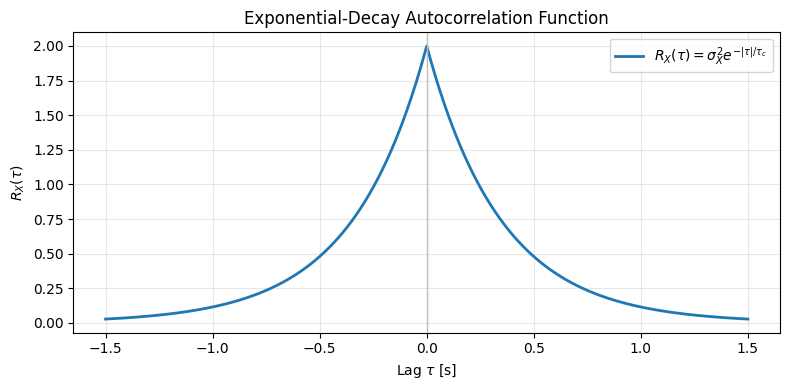

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def exponential_acf(
    tau_s: np.ndarray,  # Lag samples [s]
    sigma_x2: float,  # Process variance/power sigma_X^2
    tau_corr_s: float,  # Correlation time constant [s]
) -> np.ndarray:  # Theoretical ACF R_X(tau)
    """Computes an exponentially decaying ACF model.

    Purpose:
        Evaluate the stationary model R_X(tau) = sigma_X^2 * exp(-|tau|/tau_corr_s).

    Parameters:
        tau_s: Lag axis in seconds.
        sigma_x2: Variance/power level (must be non-negative).
        tau_corr_s: Correlation decay constant in seconds (must be positive).

    Returns:
        Array with the same shape as tau_s containing R_X(tau).

    Side effects:
        None.
    """
    if sigma_x2 < 0.0:
        raise ValueError("sigma_x2 must be non-negative.")
    if tau_corr_s <= 0.0:
        raise ValueError("tau_corr_s must be strictly positive.")

    # Enforce symmetric exponential decay around tau = 0.
    return sigma_x2 * np.exp(-np.abs(tau_s) / tau_corr_s)


# Configure simulation parameters.
sigma_x2: float = 2.0
tau_corr_s: float = 0.35
tau_max_s: float = 1.5
n_lags: int = 601

# Build lag axis and evaluate the model.
tau_s = np.linspace(-tau_max_s, tau_max_s, n_lags)
r_x_tau = exponential_acf(tau_s=tau_s, sigma_x2=sigma_x2, tau_corr_s=tau_corr_s)

# Map the continuous model to a discrete forgetting factor.
delta_tau_s = float(tau_s[1] - tau_s[0])
lambda_forgetting = float(np.exp(-delta_tau_s / tau_corr_s))
print(f"Forgetting factor lambda = {lambda_forgetting:.6f}")

# Plot the simulated theoretical ACF.
plt.figure(figsize=(8, 4))
plt.plot(tau_s, r_x_tau, lw=2, label=r"$R_X(\tau)=\sigma_X^2 e^{-|\tau|/\tau_c}$")
plt.axvline(0.0, color="0.75", lw=1)
plt.xlabel(r"Lag $\tau$ [s]")
plt.ylabel(r"$R_X(\tau)$")
plt.title("Exponential-Decay Autocorrelation Function")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Generating a Process with Exponential ACF (PyTorch)

Target discrete-time ACF:

$$
R_X[k] = \sigma_X^2\,\lambda^{|k|},\qquad 0 < \lambda < 1.
$$

This is obtained from the continuous model \(R_X(\tau)=\sigma_X^2 e^{-|\tau|/\tau_c}\) by sampling with period \(\Delta t\):

$$
\lambda = e^{-\Delta t/\tau_c}.
$$

A Gaussian AR(1) process reproduces this ACF:

$$
X[n] = \lambda X[n-1] + W[n],
$$

with white innovation \(W[n]\sim\mathcal N(0,\sigma_W^2)\), independent across \(n\).

For stationarity, variances satisfy:

$$
\sigma_X^2 = \frac{\sigma_W^2}{1-\lambda^2}
\quad\Rightarrow\quad
\sigma_W^2 = \sigma_X^2(1-\lambda^2).
$$

If the initial state is drawn as \(X[0]\sim\mathcal N(0,\sigma_X^2)\), independent of \(W[n]\), the simulated sequence is stationary from the first sample and has theoretical ACF \(R_X[k]=\sigma_X^2\lambda^{|k|}\).

FFT-based zero-padding estimator (biased normalization):

$$
\hat{R}_X[k] = \frac{1}{N}\,\mathrm{IFFT}\!\left(\left|\mathrm{FFT}(x_0[n], L)\right|^2\right)[k],
\quad k=0,\dots,k_{\max},
$$

where \(x_0[n]=x[n]-\bar{x}\), and \(L\ge 2N-1\) (implemented with next power-of-two) avoids circular wrap-around, yielding the linear autocorrelation.


In [ ]:
import math
import torch
import matplotlib.pyplot as plt


def forgetting_factor_from_tau_corr(
    dt_s: float,  # Sampling period [s]
    tau_corr_s: float,  # Correlation time constant [s]
) -> float:  # Discrete forgetting factor lambda in (0, 1)
    """Converts a continuous-time exponential decay constant into a discrete forgetting factor.

    Purpose:
        Map R_X(tau)=sigma_X^2*exp(-|tau|/tau_corr_s) to R_X[k]=sigma_X^2*lambda^|k|
        under uniform sampling with period dt_s.

    Parameters:
        dt_s: Sampling period in seconds.
        tau_corr_s: Correlation time constant in seconds.

    Returns:
        Forgetting factor lambda = exp(-dt_s/tau_corr_s).

    Side effects:
        None.
    """
    if dt_s <= 0.0:
        raise ValueError("dt_s must be strictly positive.")
    if tau_corr_s <= 0.0:
        raise ValueError("tau_corr_s must be strictly positive.")

    return float(math.exp(-dt_s / tau_corr_s))


def simulate_exponential_acf_process_torch(
    n_samples: int,  # Number of samples N [samples]
    sigma_x2: float,  # Target process variance sigma_X^2
    lambda_forgetting: float,  # AR(1) forgetting factor lambda
    seed: int = 7,  # RNG seed for deterministic simulation
    dtype: torch.dtype = torch.float64,  # Numeric precision used by torch
    device: str = "cpu",  # Execution device ("cpu" or CUDA device)
) -> torch.Tensor:  # Simulated stationary process x[n]
    """Generates a stationary Gaussian AR(1) process with the target exponential ACF.

    Purpose:
        Simulate x[n] satisfying approximately R_X[k]=sigma_X^2*lambda_forgetting^|k|
        by using x[n]=lambda*x[n-1]+w[n] with properly scaled innovations.

    Parameters:
        n_samples: Output length in samples.
        sigma_x2: Target stationary variance (must be non-negative).
        lambda_forgetting: AR(1) coefficient in [0, 1).
        seed: Seed controlling random draws.
        dtype: Torch floating dtype for outputs and intermediate arrays.
        device: Device where tensors are allocated.

    Returns:
        1D tensor x[n] with length n_samples.

    Side effects:
        Uses torch pseudorandom number generation.

    Assumptions:
        For exact stationarity from n=0, x[0] is sampled from N(0, sigma_x2).
    """
    if n_samples < 2:
        raise ValueError("n_samples must be at least 2.")
    if sigma_x2 < 0.0:
        raise ValueError("sigma_x2 must be non-negative.")
    if not (0.0 <= lambda_forgetting < 1.0):
        raise ValueError("lambda_forgetting must satisfy 0 <= lambda < 1.")

    # Match stationary AR(1) variance: sigma_W^2 = sigma_X^2 * (1 - lambda^2).
    sigma_w: float = math.sqrt(sigma_x2 * (1.0 - lambda_forgetting**2))

    # Create an explicit generator to keep randomness reproducible.
    generator = torch.Generator(device=device)
    generator.manual_seed(seed)

    x_n = torch.empty(n_samples, dtype=dtype, device=device)

    # Draw initial state from the stationary marginal distribution.
    x_n[0] = torch.randn(1, dtype=dtype, device=device, generator=generator)[0] * math.sqrt(sigma_x2)

    # Draw all innovations and run the AR(1) recursion in time order.
    w_n = torch.randn(n_samples, dtype=dtype, device=device, generator=generator) * sigma_w
    for n in range(1, n_samples):
        x_n[n] = lambda_forgetting * x_n[n - 1] + w_n[n]

    return x_n


def estimate_biased_acf_torch(
    x_n: torch.Tensor,  # Input sequence x[n]
    max_lag_samples: int,  # Maximum lag k_max [samples]
) -> torch.Tensor:  # Biased sample ACF for lags 0..k_max
    """Estimates a biased sample ACF for non-negative lags.

    Purpose:
        Provide a direct lag-domain reference estimate for validation of the FFT method.

    Parameters:
        x_n: 1D tensor containing the time-domain realization.
        max_lag_samples: Largest lag included in the estimate.

    Returns:
        Tensor r_hat[k] for k=0,...,max_lag_samples using normalization by N.

    Side effects:
        None.
    """
    if x_n.ndim != 1:
        raise ValueError("x_n must be a 1D tensor.")

    n_samples: int = int(x_n.numel())
    if not (0 <= max_lag_samples < n_samples):
        raise ValueError("max_lag_samples must be in [0, n_samples - 1].")

    # Remove empirical mean to estimate covariance-based ACF.
    x_centered = x_n - torch.mean(x_n)

    r_hat = torch.empty(max_lag_samples + 1, dtype=x_n.dtype, device=x_n.device)

    # Compute lagged inner products for each non-negative lag.
    for k in range(max_lag_samples + 1):
        r_hat[k] = torch.dot(x_centered[: n_samples - k], x_centered[k:]) / n_samples

    return r_hat


def next_power_of_two(
    value: int,  # Positive integer target value
) -> int:  # Smallest power-of-two >= value
    """Returns the smallest power-of-two greater than or equal to a target integer.

    Purpose:
        Choose an FFT length that is both efficient and large enough for linear
        autocorrelation recovery when zero-padding is required.

    Parameters:
        value: Minimum required FFT length.

    Returns:
        Power-of-two integer L satisfying L >= value.

    Side effects:
        None.
    """
    if value < 1:
        raise ValueError("value must be >= 1.")

    return 1 << (value - 1).bit_length()


def estimate_biased_acf_fft_zero_padding_torch(
    x_n: torch.Tensor,  # Input sequence x[n]
    max_lag_samples: int,  # Maximum lag k_max [samples]
) -> torch.Tensor:  # Biased ACF estimate for lags 0..k_max
    """Estimates ACF via FFT with zero-padding to recover linear correlation.

    Purpose:
        Compute the biased sample ACF efficiently from one realization x[n] using
        Wiener-Khinchin with explicit zero-padding (L >= 2N-1).

    Parameters:
        x_n: 1D real tensor containing the time-domain realization.
        max_lag_samples: Largest lag included in the estimate.

    Returns:
        Tensor r_hat_fft[k] for k=0,...,max_lag_samples normalized by N.

    Side effects:
        None.

    Assumptions:
        x_n is real-valued; empirical mean is removed before estimation.
    """
    if x_n.ndim != 1:
        raise ValueError("x_n must be a 1D tensor.")

    n_samples: int = int(x_n.numel())
    if not (0 <= max_lag_samples < n_samples):
        raise ValueError("max_lag_samples must be in [0, n_samples - 1].")

    # Remove empirical mean to estimate covariance-based ACF.
    x_centered = x_n - torch.mean(x_n)

    # Use L >= 2N-1 to avoid circular wrap-around and recover linear ACF.
    n_fft_min: int = 2 * n_samples - 1
    n_fft: int = next_power_of_two(n_fft_min)

    # Apply Wiener-Khinchin: R = IFFT{|FFT(x)|^2}.
    x_fft = torch.fft.rfft(x_centered, n=n_fft)
    spectrum = x_fft * torch.conj(x_fft)
    r_linear = torch.fft.irfft(spectrum, n=n_fft)

    # Keep non-negative lags and use biased normalization by N.
    r_hat_fft = r_linear[: max_lag_samples + 1] / n_samples
    return r_hat_fft


# Configure target ACF and simulation controls.
sigma_x2: float = 2.0
tau_corr_s: float = 0.35
dt_s: float = 0.01
n_samples: int = 50_000
max_lag_samples: int = 400
seed: int = 1

lambda_forgetting = forgetting_factor_from_tau_corr(dt_s=dt_s, tau_corr_s=tau_corr_s)
x_n = simulate_exponential_acf_process_torch(
    n_samples=n_samples,
    sigma_x2=sigma_x2,
    lambda_forgetting=lambda_forgetting,
    seed=seed,
)

# Estimate ACF from x[n] using the requested FFT + zero-padding method.
r_hat_fft = estimate_biased_acf_fft_zero_padding_torch(
    x_n=x_n,
    max_lag_samples=max_lag_samples,
)

# Compute a direct estimate as a numerical reference to verify implementation.
r_hat_direct = estimate_biased_acf_torch(x_n=x_n, max_lag_samples=max_lag_samples)

lags = torch.arange(max_lag_samples + 1, dtype=x_n.dtype, device=x_n.device)
r_theory = sigma_x2 * (lambda_forgetting ** lags)

# Build physical axes with explicit units.
time_s = torch.arange(n_samples, dtype=x_n.dtype, device=x_n.device) * dt_s
lag_s = lags * dt_s

max_abs_diff_fft_vs_direct = torch.max(torch.abs(r_hat_fft - r_hat_direct)).item()

print(f"Forgetting factor lambda = {lambda_forgetting:.6f}")
print(f"Target variance sigma_X^2 = {sigma_x2:.6f}")
print(f"Sample variance (torch) = {torch.var(x_n, unbiased=False).item():.6f}")
print(f"Max |ACF_fft - ACF_direct| = {max_abs_diff_fft_vs_direct:.3e}")

# Move tensors to CPU/NumPy for plotting with matplotlib.
time_s_np = time_s.cpu().numpy()
x_n_np = x_n.cpu().numpy()
lag_s_np = lag_s.cpu().numpy()
r_hat_fft_np = r_hat_fft.cpu().numpy()
r_hat_direct_np = r_hat_direct.cpu().numpy()
r_theory_np = r_theory.cpu().numpy()

n_time_plot_samples: int = 1200

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left panel: time-domain realization.
axes[0].plot(time_s_np[:n_time_plot_samples], x_n_np[:n_time_plot_samples], lw=1.0)
axes[0].set_title("Simulated Stochastic Process x[n] (PyTorch)")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Amplitude")
axes[0].grid(alpha=0.3)

# Right panel: FFT-based ACF estimate against theory (and direct check).
axes[1].plot(lag_s_np, r_hat_fft_np, lw=2.2, label="Sample ACF (FFT + zero-padding)")
axes[1].plot(lag_s_np, r_theory_np, "--", lw=2, label="Theory")
axes[1].plot(lag_s_np, r_hat_direct_np, ":", lw=1.5, label="Direct reference")
axes[1].set_title("ACF Match: FFT Estimation vs Theory")
axes[1].set_xlabel("Lag [s]")
axes[1].set_ylabel(r"$R_X(	au)$")
axes[1].grid(alpha=0.3)
axes[1].legend()

fig.tight_layout()
plt.show()
